# Event Study Replication (Table 2)

Replicating Mello's World Cup & GDP event study in Python.
- Uses `pyfixest` for two-way fixed effects with clustered standard errors
- First: Standard sample (1961-Q1 onwards)
- Second: Alternative sample (1962-Q1 onwards)

In [7]:
%pip install pandas numpy pyfixest matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
import pyfixest as pf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

## 1. Load Data & Apply Paper Filters

In [9]:
# Load enriched panel (already has YoY columns)
df0 = pd.read_csv('paper_replication_event_study_sample.csv')

# Paper country sets
controls = ["ARG","AUS","AUT","BEL","BGR","CAN","CHL","COL","CRI","HRV","CZE","DNK","EST","FIN",
            "GRC","HUN","IND","IDN","ISL","IRL","ISR","LVA","LTU","LUX","NLD","NZL","NOR","POL",
            "PRT","ROU","SAU","SVK","SVN","SWE","CHE","TUR"]
hosts = ["BRA","GBR","FRA","DEU","ITA","JPN","MEX","ZAF","KOR","ESP","RUS","USA"]
paper_countries = sorted(set(controls + hosts))

# Filter
df = df0[df0['country'].isin(paper_countries)].copy()
df = df[(df['quarter'] >= '1961-Q1') & (df['quarter'] <= '2021-Q4')]
df = df[~((df['country'] == 'BRA') & (df['quarter'] < '1998-Q2'))]

# Create time index
df['year'] = df['quarter'].str[:4].astype(int)
df['qtr'] = df['quarter'].str[-1].astype(int)
df['tq'] = df['year'] * 4 + df['qtr']
df = df.sort_values(['country', 'tq'])

print(f"Rows: {len(df):,}, Countries: {df['country'].nunique()}")

Rows: 8,737, Countries: 48


## 2. Define Outcome & Control Variables

In [10]:
# Column names
gdp_level = 'gross_domestic_product_chain_linked_volume_rebased_us_dollars_ppp_converted'
gdp_yoylog = f'{gdp_level}_yoy_log_4q'

# Create regression variables
df['ln_gdp'] = np.log(df[gdp_level])
df['ln_gdp_l4'] = df.groupby('country')['ln_gdp'].shift(4)
df['dy_gdp_pp'] = df[gdp_yoylog]
df['host'] = df['host'].fillna(0).astype(int)

# Keep only rows with valid outcome
df = df[df['dy_gdp_pp'].notna()]
print(f"After filtering for valid YoY: {len(df):,} rows")

After filtering for valid YoY: 8,737 rows


## 3. Define World Cup Win Events

In [11]:
# World Cup wins (l=0 is Q2 of winning year)
win_events = pd.DataFrame([
    ('GBR', 1966),  # England -> GBR
    ('DEU', 1974), ('ITA', 1982), ('DEU', 1990), ('FRA', 1998),
    ('BRA', 2002), ('ITA', 2006), ('ESP', 2010), ('DEU', 2014), ('FRA', 2018)
], columns=['country', 'year'])
win_events['qtr'] = 2
win_events['tq_event'] = win_events['year'] * 4 + win_events['qtr']

winner_countries = win_events['country'].unique()
df['winner'] = df['country'].isin(winner_countries).astype(int)

print(f"Winner countries: {sorted(winner_countries)}")
print(f"Winners obs: {df['winner'].sum():,}, Controls obs: {(1-df['winner']).sum():,}")

Winner countries: ['BRA', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA']
Winners obs: 1,315, Controls obs: 7,422


## 4. Construct Relative Event Time

In [13]:
# Assign relative time to nearest event
def assign_rel_time(ctry, tq_series):
    """Compute relative time to nearest win event for a country."""
    events = win_events[win_events['country'] == ctry]['tq_event'].values
    if len(events) > 0:
        return tq_series.apply(lambda t: min(t - events, key=abs))
    else:
        return pd.Series(0, index=tq_series.index)  # Controls: doesn't matter since winner=0

# Apply by country
df['rel_time'] = df.groupby('country').apply(
    lambda g: assign_rel_time(g.name, g['tq'])
).reset_index(level=0, drop=True)

df['rel_time_bin'] = df['rel_time'].clip(-16, 16).astype(int)

print("Event time distribution (winners only):")
print(df[df['winner']==1]['rel_time_bin'].value_counts().sort_index().head(10))

Event time distribution (winners only):
rel_time_bin
-16    535
-15     10
-14     10
-13     10
-12     10
-11     10
-10     10
-9      10
-8      10
-7      10
Name: count, dtype: int64


## 5. Estimate Event Study (Table 2)

In [17]:
# Prepare regression data (complete cases)
reg_vars = ['dy_gdp_pp', 'ln_gdp_l4', 'host', 'rel_time_bin', 'winner', 'country', 'tq']
df_reg = df[reg_vars].dropna().copy()

# Create WIN_l dummies (use m/p prefix to avoid minus sign in column names)
# WIN_m16 = l=-16, WIN_p4 = l=+4, etc.
for l in range(-16, 17):
    if l != 0:
        col_name = f'WIN_m{abs(l)}' if l < 0 else f'WIN_p{l}'
        df_reg[col_name] = ((df_reg['rel_time_bin'] == l) & (df_reg['winner'] == 1)).astype(int)

print(f"Regression sample: {len(df_reg):,} obs, {df_reg['country'].nunique()} countries")

Regression sample: 8,545 obs, 48 countries


In [18]:
# Build formula with new naming convention (WIN_m16, WIN_m15, ..., WIN_p1, ..., WIN_p16)
win_terms = ' + '.join([f'WIN_m{abs(l)}' if l < 0 else f'WIN_p{l}' for l in range(-16, 17) if l != 0])
formula = f'dy_gdp_pp ~ {win_terms} + host + ln_gdp_l4 | country + tq'

model = pf.feols(formula, data=df_reg, vcov={'CRV1': 'country'})
print(model.summary())

###

Estimation:  OLS
Dep. var.: dy_gdp_pp, Fixed effects: country+tq
Inference:  CRV1
Observations:  8545

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| WIN_m16       |      0.774 |        0.664 |     1.166 |      0.249 | -0.561 |   2.109 |
| WIN_m15       |      0.705 |        0.454 |     1.554 |      0.127 | -0.208 |   1.618 |
| WIN_m14       |      0.751 |        0.543 |     1.383 |      0.173 | -0.341 |   1.842 |
| WIN_m13       |      0.512 |        0.447 |     1.146 |      0.258 | -0.387 |   1.412 |
| WIN_m12       |      0.035 |        0.480 |     0.073 |      0.942 | -0.930 |   1.000 |
| WIN_m11       |     -0.160 |        0.586 |    -0.273 |      0.786 | -1.339 |   1.019 |
| WIN_m10       |      0.229 |        0.725 |     0.316 |      0.754 | -1.230 |   1.687 |
| WIN_m9        |      0.022 |        0.589 |     0.037 |      0.971 | -1.163 |   

## 6. Table 2 Coefficients

In [20]:
# Extract coefficients
def extract_coef_table(m):
    coef_df = pd.DataFrame({
        'term': m.coef().index, 'estimate': m.coef().values, 'se': m.se().values
    })
    # Parse event time from WIN_m16 (=-16) or WIN_p4 (=+4) format
    def parse_l(t):
        if t.startswith('WIN_m'):
            return -int(t.replace('WIN_m', ''))
        elif t.startswith('WIN_p'):
            return int(t.replace('WIN_p', ''))
        return None
    coef_df['l'] = coef_df['term'].apply(parse_l)
    coef_df['sort_key'] = coef_df.apply(
        lambda r: -999 if r['term'] == 'ln_gdp_l4' else (-998 if r['term'] == 'host' else (r['l'] if r['l'] is not None else 999)), axis=1)
    return coef_df.sort_values('sort_key')

coef_df = extract_coef_table(model)
print("\nTABLE 2: Event Study Coefficients")
print("=" * 50)
print(coef_df[['term', 'estimate', 'se', 'l']].to_string(index=False))


TABLE 2: Event Study Coefficients
     term  estimate     se        l
ln_gdp_l4   -1.2953 0.6198      NaN
     host   -0.5643 0.4881      NaN
  WIN_m16    0.7741 0.6638 -16.0000
  WIN_m15    0.7050 0.4537 -15.0000
  WIN_m14    0.7506 0.5427 -14.0000
  WIN_m13    0.5124 0.4471 -13.0000
  WIN_m12    0.0352 0.4797 -12.0000
  WIN_m11   -0.1598 0.5860 -11.0000
  WIN_m10    0.2289 0.7251 -10.0000
   WIN_m9    0.0217 0.5891  -9.0000
   WIN_m8    0.1799 0.6857  -8.0000
   WIN_m7    0.3104 0.5771  -7.0000
   WIN_m6    0.2193 0.5931  -6.0000
   WIN_m5    0.5606 0.5948  -5.0000
   WIN_m4    0.0145 0.5374  -4.0000
   WIN_m3   -0.2285 0.4910  -3.0000
   WIN_m2   -0.5589 0.4501  -2.0000
   WIN_m1    0.0641 0.2326  -1.0000
   WIN_p1    0.3197 0.2702   1.0000
   WIN_p2    0.5929 0.3873   2.0000
   WIN_p3    0.3315 0.3191   3.0000
   WIN_p4    0.3166 0.3144   4.0000
   WIN_p5    0.0775 0.3696   5.0000
   WIN_p6    0.2183 0.4051   6.0000
   WIN_p7   -0.0366 0.6615   7.0000
   WIN_p8    0.0857 0.7791   

## 7. Plot Event Study

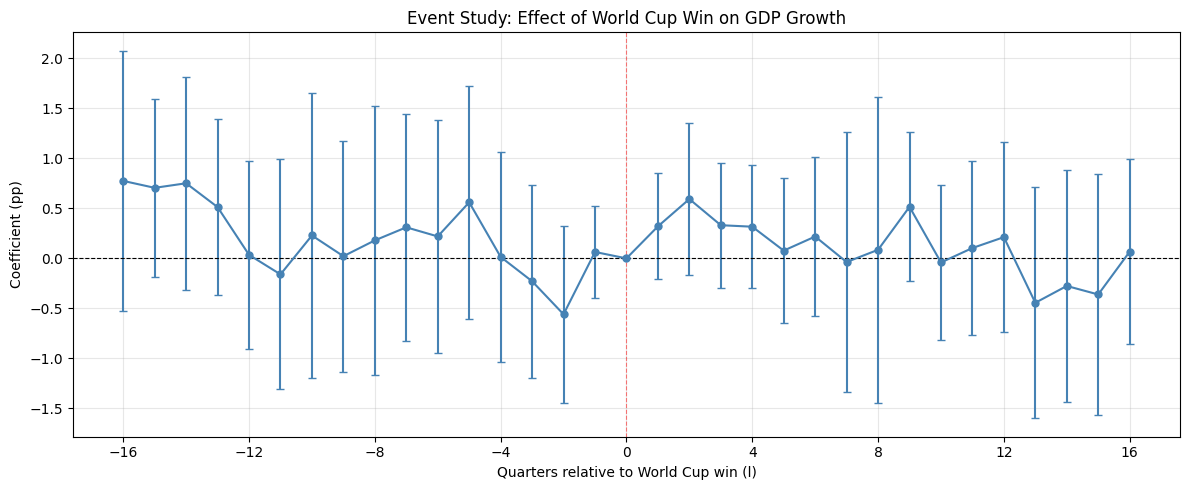

In [21]:
# Plot event study coefficients
plot_df = coef_df[coef_df['l'].notna()].copy()
ref_row = pd.DataFrame({'term': ['WIN_0'], 'estimate': [0], 'se': [0], 'l': [0], 'sort_key': [0]})
plot_df = pd.concat([plot_df, ref_row]).sort_values('l')

fig, ax = plt.subplots(figsize=(12, 5))
ax.errorbar(plot_df['l'], plot_df['estimate'], yerr=1.96*plot_df['se'], 
            fmt='o-', capsize=3, markersize=5, color='steelblue')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Quarters relative to World Cup win (l)')
ax.set_ylabel('Coefficient (pp)')
ax.set_title('Event Study: Effect of World Cup Win on GDP Growth')
ax.set_xticks(range(-16, 17, 4))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# Alternative Sample: Starting from 1962

Since YoY growth requires 4 quarters of history, if GDP data starts in 1961, valid YoY is only available from 1962-Q1.

In [22]:
# Reload and filter to 1962 onwards
df_alt = df0[df0['country'].isin(paper_countries)].copy()
df_alt = df_alt[(df_alt['quarter'] >= '1962-Q1') & (df_alt['quarter'] <= '2021-Q4')]
df_alt = df_alt[~((df_alt['country'] == 'BRA') & (df_alt['quarter'] < '1998-Q2'))]

# Time index and variables
df_alt['year'] = df_alt['quarter'].str[:4].astype(int)
df_alt['qtr'] = df_alt['quarter'].str[-1].astype(int)
df_alt['tq'] = df_alt['year'] * 4 + df_alt['qtr']
df_alt = df_alt.sort_values(['country', 'tq'])

df_alt['ln_gdp'] = np.log(df_alt[gdp_level])
df_alt['ln_gdp_l4'] = df_alt.groupby('country')['ln_gdp'].shift(4)
df_alt['dy_gdp_pp'] = df_alt[gdp_yoylog]
df_alt['host'] = df_alt['host'].fillna(0).astype(int)
df_alt = df_alt[df_alt['dy_gdp_pp'].notna()]
df_alt['winner'] = df_alt['country'].isin(winner_countries).astype(int)

# Relative time (reuse assign_rel_time from above)
df_alt['rel_time'] = df_alt.groupby('country').apply(
    lambda g: assign_rel_time(g.name, g['tq'])
).reset_index(level=0, drop=True)
df_alt['rel_time_bin'] = df_alt['rel_time'].clip(-16, 16).astype(int)

print(f"Alternative sample (1962+): {len(df_alt):,} rows, {df_alt['country'].nunique()} countries")

Alternative sample (1962+): 8,633 rows, 48 countries


In [23]:
# Estimate alternative model
df_reg_alt = df_alt[reg_vars].dropna().copy()
for l in range(-16, 17):
    if l != 0:
        col_name = f'WIN_m{abs(l)}' if l < 0 else f'WIN_p{l}'
        df_reg_alt[col_name] = ((df_reg_alt['rel_time_bin'] == l) & (df_reg_alt['winner'] == 1)).astype(int)

model_alt = pf.feols(formula, data=df_reg_alt, vcov={'CRV1': 'country'})

print("=" * 60)
print("ALTERNATIVE SAMPLE (1962 onwards)")
print("=" * 60)
print(model_alt.summary())

ALTERNATIVE SAMPLE (1962 onwards)
###

Estimation:  OLS
Dep. var.: dy_gdp_pp, Fixed effects: country+tq
Inference:  CRV1
Observations:  8441

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| WIN_m16       |      0.752 |        0.666 |     1.129 |      0.265 | -0.588 |   2.092 |
| WIN_m15       |      1.041 |        0.413 |     2.523 |      0.015 |  0.211 |   1.872 |
| WIN_m14       |      1.096 |        0.519 |     2.114 |      0.040 |  0.053 |   2.140 |
| WIN_m13       |      0.524 |        0.446 |     1.176 |      0.245 | -0.373 |   1.421 |
| WIN_m12       |      0.044 |        0.480 |     0.092 |      0.927 | -0.921 |   1.009 |
| WIN_m11       |     -0.151 |        0.586 |    -0.258 |      0.798 | -1.330 |   1.028 |
| WIN_m10       |      0.237 |        0.726 |     0.326 |      0.746 | -1.223 |   1.697 |
| WIN_m9        |      0.029 |        0.590 |   

In [24]:
# Extract alternative coefficients
coef_alt = extract_coef_table(model_alt)

print("\nTABLE 2 (Alternative 1962+): Event Study Coefficients")
print("=" * 50)
print(coef_alt[['term', 'estimate', 'se']].to_string(index=False))


TABLE 2 (Alternative 1962+): Event Study Coefficients
     term  estimate     se
ln_gdp_l4   -1.4211 0.6678
     host   -0.5489 0.4936
  WIN_m16    0.7519 0.6660
  WIN_m15    1.0413 0.4128
  WIN_m14    1.0964 0.5186
  WIN_m13    0.5244 0.4459
  WIN_m12    0.0440 0.4798
  WIN_m11   -0.1512 0.5861
  WIN_m10    0.2369 0.7257
   WIN_m9    0.0289 0.5899
   WIN_m8    0.1871 0.6862
   WIN_m7    0.3172 0.5776
   WIN_m6    0.2260 0.5934
   WIN_m5    0.5665 0.5947
   WIN_m4    0.0207 0.5372
   WIN_m3   -0.2226 0.4911
   WIN_m2   -0.5531 0.4503
   WIN_m1    0.0691 0.2329
   WIN_p1    0.3266 0.2695
   WIN_p2    0.5993 0.3860
   WIN_p3    0.3350 0.3196
   WIN_p4    0.3195 0.3149
   WIN_p5    0.0805 0.3696
   WIN_p6    0.2210 0.4053
   WIN_p7   -0.0341 0.6612
   WIN_p8    0.0875 0.7785
   WIN_p9    0.5169 0.3790
  WIN_p10   -0.0394 0.3955
  WIN_p11    0.1047 0.4437
  WIN_p12    0.2127 0.4842
  WIN_p13   -0.4430 0.5876
  WIN_p14   -0.2756 0.5909
  WIN_p15   -0.3601 0.6158
  WIN_p16    0.0282 0.4562


## Compare Standard vs Alternative

In [25]:
# Side-by-side comparison
compare = coef_df[['term', 'estimate', 'se']].merge(
    coef_alt[['term', 'estimate', 'se']], on='term', suffixes=('_std', '_alt'))
compare['diff'] = compare['estimate_alt'] - compare['estimate_std']

# Key terms
key_terms = ['ln_gdp_l4', 'host'] + [f'WIN_{l}' for l in [-16, -12, -8, -4, 4, 8, 12, 16]]
print("\nCOMPARISON: Standard (1961+) vs Alternative (1962+)")
print("=" * 70)
print(compare[compare['term'].isin(key_terms)].to_string(index=False))


COMPARISON: Standard (1961+) vs Alternative (1962+)
     term  estimate_std  se_std  estimate_alt  se_alt    diff
ln_gdp_l4       -1.2953  0.6198       -1.4211  0.6678 -0.1257
     host       -0.5643  0.4881       -0.5489  0.4936  0.0154


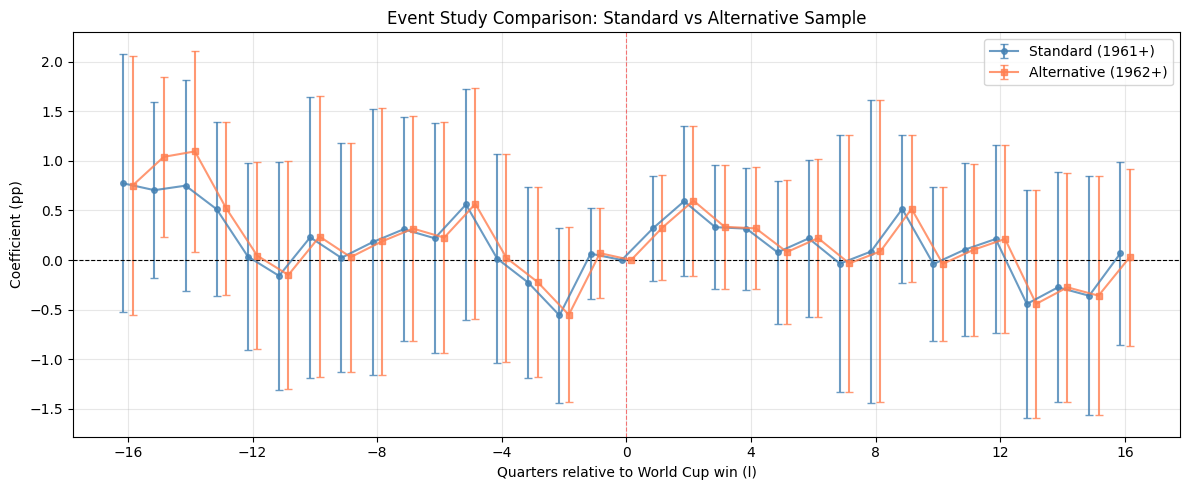

In [26]:
# Plot both on same figure
plot_std = coef_df[coef_df['l'].notna()].copy()
plot_alt_df = coef_alt[coef_alt['l'].notna()].copy()
ref = pd.DataFrame({'l': [0], 'estimate': [0], 'se': [0]})
plot_std = pd.concat([plot_std, ref]).sort_values('l')
plot_alt_df = pd.concat([plot_alt_df, ref]).sort_values('l')

fig, ax = plt.subplots(figsize=(12, 5))
ax.errorbar(plot_std['l'] - 0.15, plot_std['estimate'], yerr=1.96*plot_std['se'], 
            fmt='o-', capsize=3, markersize=4, color='steelblue', label='Standard (1961+)', alpha=0.8)
ax.errorbar(plot_alt_df['l'] + 0.15, plot_alt_df['estimate'], yerr=1.96*plot_alt_df['se'], 
            fmt='s-', capsize=3, markersize=4, color='coral', label='Alternative (1962+)', alpha=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Quarters relative to World Cup win (l)')
ax.set_ylabel('Coefficient (pp)')
ax.set_title('Event Study Comparison: Standard vs Alternative Sample')
ax.set_xticks(range(-16, 17, 4))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()